<img src="scvi_more_accurate.png" width="600">

In [1]:

# various import statements
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions.util import broadcast_shape
from pyro.optim import MultiStepLR
from pyro.infer import SVI, config_enumerate, TraceEnum_ELBO, Trace_ELBO, TraceMeanField_ELBO
from pyro.contrib.examples.scanvi_data import get_data
from pyro import poutine 
from torch.optim import Adam



import scanpy as sc

import torch.utils.data as data_utils

from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from tqdm import tqdm

pyro.enable_validation(True)

In [2]:
### to use kl-annealing enclose the latent parameters with poutine.scale 


In [3]:

sc.set_figure_params(figsize=(4, 4))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'


### util functions

In [4]:
# Splits a tensor in half along the final dimension
def split_in_half(t):
    """
    taken from pyro tutorial scanVI
    """

    return t.reshape(t.shape[:-1] + (2, -1)).unbind(-2)

    

# Helper for making fully-connected neural networks
def make_fc(dims):
    
    """
    take from pyro tutorial creates eg. usage 
    latent_dims = 10
    n_input = num_genes
    hidden_dims = [128, 128]
    
    dims = [latent_dims] + hidden_dims + [2 * num_genes]
    returns : 
            Sequential(
                      (0): Linear(in_features=10, out_features=128, bias=True)
                      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                      (2): ReLU()
                      (3): Linear(in_features=128, out_features=128, bias=True)
                      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                      (5): ReLU()
                      (6): Linear(in_features=128, out_features=43864, bias=True)
                      (7): BatchNorm1d(43864, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                    )

    """
    
    layers = []
    for in_dim, out_dim in zip(dims, dims[1:]):
        layers.append(nn.Linear(in_dim, out_dim))
        layers.append(nn.BatchNorm1d(out_dim))
        layers.append(nn.ReLU())
    return nn.Sequential(*layers[:-1])  # Exclude final ReLU non-linearity



### nn modules

In [5]:
class z_decoder(nn.Module):
    
    """
    decoder which maps the latent space to the parameters of the distribution
    """
    
    def __init__(self, gene_likelihood, n_input, n_output, n_layers, n_hidden , dropout, apply_nonlinearity ):
        
        super(z_decoder, self).__init__()
        
        self.final_non_linearity = nn.Softmax(dim = -1)
        self.gene_likelihood  = gene_likelihood
        self.apply_nonlinearity = apply_nonlinearity
        
        if self.gene_likelihood == "zinb":
            self.core_net = make_fc([n_input] + [n_hidden]*(n_layers-1) + [n_hidden])
            self.mu_net = nn.Linear(n_hidden, n_output)
            self.gate_net = nn.Linear(n_hidden, n_output)
        else:
            self.net = make_fc([n_input] + [n_hidden]*n_layers + [n_output])
            
        
        
    def forward(self, x_n, s_n):
        
        inp = torch.hstack([x_n, s_n[:, None]])
        
        
        if self.gene_likelihood == "zinb":
            x = self.core_net(inp)
            gate_logits = self.gate_net(x)
            mu = self.mu_net(x)
            
        else:
            mu = self.net(x)
            
        if self.apply_nonlinearity:
            mu = self.final_non_linearity(mu) 
            
        if self.gene_likelihood == "zinb":
            return mu, gate_logits
        else:
            return mu    

    
    
class z_encoder(nn.Module):
    """
    encoder which maps the input space to the latent code generating the data 
    """
    
    def __init__(self, n_input, n_output, n_layers, n_hidden , dropout ):
        
        super(z_encoder, self).__init__()
        self.net = make_fc([n_input] + [n_hidden]*n_layers + [n_output])
        
        
    
    
    def forward(self, x_n, s_n):
        
        
        inp_count_log1p = torch.log(1+x_n)
        
        inp = torch.hstack([inp_count_log1p, s_n[:, None]])
        
        
        net_out = self.net(inp)
        
        
        z_code = net_out[..., :-2]
        l_code = net_out[..., -2:]
        
        z_mu, z_log_var = split_in_half(z_code)
        l_mean, l_log_var = split_in_half(l_code)
        
        z_scale = F.softplus(z_log_var)
        l_scale = F.softplus(l_log_var)
        
        
        return z_mu, z_scale, l_mean, l_scale
    

In [6]:
USE_CUDA = True

In [7]:

class scVI_laplace(nn.Module):
    
    """
    has a very basic construction really 
    model, guide and the observation model
    
    """
    
    
    def __init__(self, 
                 gene_likelihood, 
                 latent_dims, 
                 num_genes, 
                 n_layers, 
                 hidden_dim, 
                 dropout_rate, 
                 l_mean_prior, 
                 l_scale_prior, 
                 batch_size , 
                 scale_factor, 
                 use_cuda = USE_CUDA):
        
        
        super().__init__()
        
        

        
            
        self.use_cuda = use_cuda
        self.latent_dims = latent_dims
        self.num_genes = num_genes
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        self.l_mean_prior = l_mean_prior
        self.l_scale_prior = l_scale_prior
        self.batch_size = batch_size
        self.scale_factor = scale_factor
        self.gene_likelihood = gene_likelihood
        self.epsilon = 0.006
        
        self.z_enc = z_encoder(1+num_genes, 2+2*latent_dims, n_layers, hidden_dim, dropout_rate).cuda()
        
        if self.gene_likelihood == "zinb":
            self.z_dec = z_decoder(self.gene_likelihood,1+latent_dims, num_genes, n_layers, hidden_dim, dropout_rate,apply_nonlinearity = True).cuda()
        else:
            self.z_dec = z_decoder(self.gene_likelihood,1+latent_dims, num_genes, n_layers, hidden_dim, dropout_rate,apply_nonlinearity = True).cuda()

        self.prior_mu = torch.zeros(self.latent_dims).cuda()
        self.prior_scale = torch.ones(self.latent_dims).cuda()
        self.nice_one = torch.ones((self.batch_size, 1 ) ).cuda()

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()

    def model(self, x_n, s_n):
        """
        define the generative process of the data
        takes in the latent code and generates the data 

        data = z_latent + [batch_idx]

        """
        
        pyro.module("decoder", self.z_dec)
        
        
        if self.gene_likelihood in ["zinb", "nb"]:
            θ = pyro.param("total_counts", 5.*torch.ones(num_genes).cuda(), constraint = constraints.greater_than(0.01))

        with pyro.plate("generative", x_n.shape[0]), poutine.scale(scale=self.scale_factor):
            
            z_n = pyro.sample("latent_code", dist.Laplace(self.prior_mu, 0.5*self.prior_scale).to_event(1) ) 
            
            
            l_scale =  self.l_scale_prior*self.nice_one
            l_mean = self.l_mean_prior*self.nice_one
            l_n = pyro.sample("library_scaling", dist.LogNormal(l_mean, l_scale).to_event(1) )
                    
            if self.gene_likelihood == "zinb":
                mu, gate_logits = self.z_dec(z_n, s_n.squeeze())
                nb_logits = (l_n * mu + self.epsilon).log() - (θ + self.epsilon).log()# + 1e-3
                #print (nb_logits > )
                dist_obs = dist.ZeroInflatedNegativeBinomial(total_count = θ, logits = nb_logits, gate_logits = gate_logits, validate_args=False).to_event(1)

            elif self.gene_likelihood == "nb":
                mu= self.z_dec(z_n, s_n)                
                nb_logits = (l_n * mu + self.epsilon).log() - (θ + self.epsilon).log()
                dist_obs = dist.NegativeBinomial(total_count = θ, logits = nb_logits ).to_event(1)
                
            elif self.gene_likelihood == "poisson":
                λ = l_n*self.z_dec(z_n, s_n) + self.epsilon
                dist_obs = dist.Poisson(λ).to_event(1)

            pyro.sample("obs", dist_obs, obs = x_n)


    def guide(self, x_n, s_n):

        pyro.module("encoder", self.z_enc)
        
        
        with pyro.plate("generative", x_n.shape[0]), poutine.scale(scale=self.scale_factor):

            z_mu, z_scale, l_mu, l_scale = self.z_enc(x_n, s_n)
            z_n = pyro.sample("latent_code", dist.Laplace(z_mu, 0.5*z_scale).to_event(1)  )     
            l_n = pyro.sample("library_scaling", dist.LogNormal(l_mu, l_scale).to_event(1) )

    
    

## read in the data 

In [8]:
adata = sc.read_h5ad("tabula_muris_processed.h5ad")

In [9]:
## get the l_mean and l_scale priors
cnt = adata.X.toarray().sum(1)
cnt = np.log1p(cnt)
l_mean_prior, l_scale_prior = cnt.mean(), cnt.std()
l_mean_prior, l_scale_prior

(5.689011, 0.28705895)

In [10]:
num_genes = 2000

In [11]:
batch_size = 128
scale_factor = 1/(batch_size * num_genes)


In [12]:
scvi_model = scVI_laplace(gene_likelihood = "zinb",
                  latent_dims = 10, 
                  num_genes = num_genes, 
                  n_layers = 2, 
                  hidden_dim = 128, 
                  dropout_rate = .1, 
                  l_mean_prior = l_mean_prior,
                  l_scale_prior = l_scale_prior, 
                  batch_size = 128, 
                  scale_factor = scale_factor, 
                  use_cuda=USE_CUDA)


In [13]:
x_n = torch.tensor(adata.layers["counts"].toarray())
s_n = adata.obs["tech"].to_numpy()
s_n_l, s_n = np.unique(s_n, return_inverse=True)
s_n = torch.tensor(s_n)

In [14]:

scheduler = MultiStepLR({'optimizer': Adam,
                         'optim_args': {'lr': 0.006},
                         'gamma': 0.2, 'milestones': [20]})
loss = TraceMeanField_ELBO()

svi = SVI(scvi_model.model, scvi_model.guide, scheduler, loss)

In [15]:
def train(svi, train_loader, use_cuda=USE_CUDA):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x_n, s_n  in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if len(x_n) != 128:
            pass
        else:
            if use_cuda:

                x_n = x_n.cuda()
                s_n = s_n.cuda()
            else:
                x_n = x_n[0]
            # do ELBO gradient and accumulate loss
            epoch_loss += svi.step(x_n, s_n)
        scheduler.step()
    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [16]:


    
traindataset = data_utils.TensorDataset(x_n.cuda(), s_n.cuda())
train_loader = data_utils.DataLoader(traindataset, batch_size=128, shuffle=True )


In [17]:
NUM_EPOCHS = 400
# clear param store
pyro.clear_param_store()



train_elbo = []
# training loop
for epoch in tqdm(range(NUM_EPOCHS)):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.5f" % (epoch, total_epoch_loss_train))

    

  0%|                                           | 1/400 [00:01<07:18,  1.10s/it]

[epoch 000]  average training loss: 1.36684


  0%|▏                                          | 2/400 [00:02<06:55,  1.04s/it]

[epoch 001]  average training loss: 1.20412


  1%|▎                                          | 3/400 [00:03<07:01,  1.06s/it]

[epoch 002]  average training loss: 1.11401


  1%|▍                                          | 4/400 [00:04<07:17,  1.11s/it]

[epoch 003]  average training loss: 1.04610


  1%|▌                                          | 5/400 [00:05<06:58,  1.06s/it]

[epoch 004]  average training loss: 0.97758


  2%|▋                                          | 6/400 [00:06<07:01,  1.07s/it]

[epoch 005]  average training loss: 0.92407


  2%|▊                                          | 7/400 [00:07<07:02,  1.07s/it]

[epoch 006]  average training loss: 0.87857


  2%|▊                                          | 8/400 [00:08<06:49,  1.04s/it]

[epoch 007]  average training loss: 0.82947


  2%|▉                                          | 9/400 [00:09<06:49,  1.05s/it]

[epoch 008]  average training loss: 0.77670


  2%|█                                         | 10/400 [00:10<06:43,  1.03s/it]

[epoch 009]  average training loss: 0.72976


  3%|█▏                                        | 11/400 [00:11<06:43,  1.04s/it]

[epoch 010]  average training loss: 0.68149


  3%|█▎                                        | 12/400 [00:12<07:19,  1.13s/it]

[epoch 011]  average training loss: 0.64340


  3%|█▎                                        | 13/400 [00:14<07:49,  1.21s/it]

[epoch 012]  average training loss: 0.59489


  4%|█▍                                        | 14/400 [00:15<07:33,  1.17s/it]

[epoch 013]  average training loss: 0.56267


  4%|█▌                                        | 15/400 [00:16<07:18,  1.14s/it]

[epoch 014]  average training loss: 0.53247


  4%|█▋                                        | 16/400 [00:17<07:21,  1.15s/it]

[epoch 015]  average training loss: 0.49577


  4%|█▊                                        | 17/400 [00:18<07:05,  1.11s/it]

[epoch 016]  average training loss: 0.46249


  4%|█▉                                        | 18/400 [00:19<06:58,  1.10s/it]

[epoch 017]  average training loss: 0.42848


  5%|█▉                                        | 19/400 [00:20<06:51,  1.08s/it]

[epoch 018]  average training loss: 0.40036


  5%|██                                        | 20/400 [00:21<06:47,  1.07s/it]

[epoch 019]  average training loss: 0.37760


  5%|██▏                                       | 21/400 [00:22<06:41,  1.06s/it]

[epoch 020]  average training loss: 0.35358


  6%|██▎                                       | 22/400 [00:24<06:51,  1.09s/it]

[epoch 021]  average training loss: 0.32748


  6%|██▍                                       | 23/400 [00:25<06:48,  1.08s/it]

[epoch 022]  average training loss: 0.30943


  6%|██▌                                       | 24/400 [00:26<06:51,  1.09s/it]

[epoch 023]  average training loss: 0.28583


  6%|██▋                                       | 25/400 [00:27<06:44,  1.08s/it]

[epoch 024]  average training loss: 0.26901


  6%|██▋                                       | 26/400 [00:28<06:34,  1.06s/it]

[epoch 025]  average training loss: 0.25121


  7%|██▊                                       | 27/400 [00:29<06:46,  1.09s/it]

[epoch 026]  average training loss: 0.23611


  7%|██▉                                       | 28/400 [00:30<06:33,  1.06s/it]

[epoch 027]  average training loss: 0.21608


  7%|███                                       | 29/400 [00:31<06:16,  1.02s/it]

[epoch 028]  average training loss: 0.20421


  8%|███▏                                      | 30/400 [00:32<06:18,  1.02s/it]

[epoch 029]  average training loss: 0.19245


  8%|███▎                                      | 31/400 [00:33<06:24,  1.04s/it]

[epoch 030]  average training loss: 0.17872


  8%|███▎                                      | 32/400 [00:34<06:20,  1.03s/it]

[epoch 031]  average training loss: 0.16568


  8%|███▍                                      | 33/400 [00:35<06:16,  1.03s/it]

[epoch 032]  average training loss: 0.15584


  8%|███▌                                      | 34/400 [00:36<06:26,  1.06s/it]

[epoch 033]  average training loss: 0.14595


  9%|███▋                                      | 35/400 [00:37<06:24,  1.05s/it]

[epoch 034]  average training loss: 0.13562


  9%|███▊                                      | 36/400 [00:38<06:22,  1.05s/it]

[epoch 035]  average training loss: 0.12771


  9%|███▉                                      | 37/400 [00:39<06:23,  1.06s/it]

[epoch 036]  average training loss: 0.11959


 10%|███▉                                      | 38/400 [00:40<06:18,  1.04s/it]

[epoch 037]  average training loss: 0.11279


 10%|████                                      | 39/400 [00:41<06:24,  1.07s/it]

[epoch 038]  average training loss: 0.10528


 10%|████▏                                     | 40/400 [00:42<06:14,  1.04s/it]

[epoch 039]  average training loss: 0.09894


 10%|████▎                                     | 41/400 [00:43<06:09,  1.03s/it]

[epoch 040]  average training loss: 0.09370


 10%|████▍                                     | 42/400 [00:44<06:03,  1.02s/it]

[epoch 041]  average training loss: 0.08692


 11%|████▌                                     | 43/400 [00:45<05:55,  1.00it/s]

[epoch 042]  average training loss: 0.08314


 11%|████▌                                     | 44/400 [00:46<05:52,  1.01it/s]

[epoch 043]  average training loss: 0.07731


 11%|████▋                                     | 45/400 [00:48<06:16,  1.06s/it]

[epoch 044]  average training loss: 0.07404


 12%|████▊                                     | 46/400 [00:49<06:20,  1.07s/it]

[epoch 045]  average training loss: 0.07069


 12%|████▉                                     | 47/400 [00:50<06:01,  1.02s/it]

[epoch 046]  average training loss: 0.06642


 12%|█████                                     | 48/400 [00:51<06:02,  1.03s/it]

[epoch 047]  average training loss: 0.06301


 12%|█████▏                                    | 49/400 [00:52<06:14,  1.07s/it]

[epoch 048]  average training loss: 0.06035


 12%|█████▎                                    | 50/400 [00:53<06:09,  1.06s/it]

[epoch 049]  average training loss: 0.05728


 13%|█████▎                                    | 51/400 [00:54<06:08,  1.05s/it]

[epoch 050]  average training loss: 0.05392


 13%|█████▍                                    | 52/400 [00:55<05:59,  1.03s/it]

[epoch 051]  average training loss: 0.05152


 13%|█████▌                                    | 53/400 [00:56<05:59,  1.04s/it]

[epoch 052]  average training loss: 0.04910


 14%|█████▋                                    | 54/400 [00:57<06:01,  1.05s/it]

[epoch 053]  average training loss: 0.04750


 14%|█████▊                                    | 55/400 [00:58<05:48,  1.01s/it]

[epoch 054]  average training loss: 0.04489


 14%|█████▉                                    | 56/400 [00:59<05:41,  1.01it/s]

[epoch 055]  average training loss: 0.04273


 14%|█████▉                                    | 57/400 [01:00<05:41,  1.01it/s]

[epoch 056]  average training loss: 0.04093


 14%|██████                                    | 58/400 [01:01<05:45,  1.01s/it]

[epoch 057]  average training loss: 0.03982


 15%|██████▏                                   | 59/400 [01:02<05:43,  1.01s/it]

[epoch 058]  average training loss: 0.03856


 15%|██████▎                                   | 60/400 [01:03<05:40,  1.00s/it]

[epoch 059]  average training loss: 0.03672


 15%|██████▍                                   | 61/400 [01:04<05:44,  1.02s/it]

[epoch 060]  average training loss: 0.03532


 16%|██████▌                                   | 62/400 [01:05<05:41,  1.01s/it]

[epoch 061]  average training loss: 0.03399


 16%|██████▌                                   | 63/400 [01:06<05:39,  1.01s/it]

[epoch 062]  average training loss: 0.03321


 16%|██████▋                                   | 64/400 [01:07<05:44,  1.03s/it]

[epoch 063]  average training loss: 0.03160


 16%|██████▊                                   | 65/400 [01:08<05:36,  1.00s/it]

[epoch 064]  average training loss: 0.03088


 16%|██████▉                                   | 66/400 [01:09<05:28,  1.02it/s]

[epoch 065]  average training loss: 0.02954


 17%|███████                                   | 67/400 [01:10<05:27,  1.02it/s]

[epoch 066]  average training loss: 0.02901


 17%|███████▏                                  | 68/400 [01:11<05:32,  1.00s/it]

[epoch 067]  average training loss: 0.02791


 17%|███████▏                                  | 69/400 [01:12<05:31,  1.00s/it]

[epoch 068]  average training loss: 0.02716


 18%|███████▎                                  | 70/400 [01:13<05:40,  1.03s/it]

[epoch 069]  average training loss: 0.02642


 18%|███████▍                                  | 71/400 [01:14<05:40,  1.04s/it]

[epoch 070]  average training loss: 0.02537


 18%|███████▌                                  | 72/400 [01:15<05:42,  1.04s/it]

[epoch 071]  average training loss: 0.02478


 18%|███████▋                                  | 73/400 [01:16<05:31,  1.01s/it]

[epoch 072]  average training loss: 0.02403


 18%|███████▊                                  | 74/400 [01:17<05:25,  1.00it/s]

[epoch 073]  average training loss: 0.02381


 19%|███████▉                                  | 75/400 [01:18<05:23,  1.00it/s]

[epoch 074]  average training loss: 0.02315


 19%|███████▉                                  | 76/400 [01:19<05:26,  1.01s/it]

[epoch 075]  average training loss: 0.02234


 19%|████████                                  | 77/400 [01:20<05:23,  1.00s/it]

[epoch 076]  average training loss: 0.02193


 20%|████████▏                                 | 78/400 [01:21<05:24,  1.01s/it]

[epoch 077]  average training loss: 0.02152


 20%|████████▎                                 | 79/400 [01:22<05:22,  1.00s/it]

[epoch 078]  average training loss: 0.02069


 20%|████████▍                                 | 80/400 [01:23<05:25,  1.02s/it]

[epoch 079]  average training loss: 0.02029


 20%|████████▌                                 | 81/400 [01:24<05:28,  1.03s/it]

[epoch 080]  average training loss: 0.01976


 20%|████████▌                                 | 82/400 [01:25<05:25,  1.02s/it]

[epoch 081]  average training loss: 0.01944


 21%|████████▋                                 | 83/400 [01:26<05:35,  1.06s/it]

[epoch 082]  average training loss: 0.01907


 21%|████████▊                                 | 84/400 [01:27<05:22,  1.02s/it]

[epoch 083]  average training loss: 0.01858


 21%|████████▉                                 | 85/400 [01:28<05:15,  1.00s/it]

[epoch 084]  average training loss: 0.01838


 22%|█████████                                 | 86/400 [01:29<05:11,  1.01it/s]

[epoch 085]  average training loss: 0.01778


 22%|█████████▏                                | 87/400 [01:30<05:06,  1.02it/s]

[epoch 086]  average training loss: 0.01762


 22%|█████████▏                                | 88/400 [01:31<05:20,  1.03s/it]

[epoch 087]  average training loss: 0.01705


 22%|█████████▎                                | 89/400 [01:32<05:26,  1.05s/it]

[epoch 088]  average training loss: 0.01691


 22%|█████████▍                                | 90/400 [01:33<05:24,  1.05s/it]

[epoch 089]  average training loss: 0.01654


 23%|█████████▌                                | 91/400 [01:34<05:18,  1.03s/it]

[epoch 090]  average training loss: 0.01615


 23%|█████████▋                                | 92/400 [01:35<05:22,  1.05s/it]

[epoch 091]  average training loss: 0.01591


 23%|█████████▊                                | 93/400 [01:36<05:19,  1.04s/it]

[epoch 092]  average training loss: 0.01559


 24%|█████████▊                                | 94/400 [01:37<05:14,  1.03s/it]

[epoch 093]  average training loss: 0.01534


 24%|█████████▉                                | 95/400 [01:38<05:09,  1.02s/it]

[epoch 094]  average training loss: 0.01508


 24%|██████████                                | 96/400 [01:39<05:07,  1.01s/it]

[epoch 095]  average training loss: 0.01488


 24%|██████████▏                               | 97/400 [01:40<05:02,  1.00it/s]

[epoch 096]  average training loss: 0.01462


 24%|██████████▎                               | 98/400 [01:41<05:01,  1.00it/s]

[epoch 097]  average training loss: 0.01435


 25%|██████████▍                               | 99/400 [01:42<05:05,  1.01s/it]

[epoch 098]  average training loss: 0.01417


 25%|██████████▎                              | 100/400 [01:43<05:00,  1.00s/it]

[epoch 099]  average training loss: 0.01393


 25%|██████████▎                              | 101/400 [01:44<04:57,  1.00it/s]

[epoch 100]  average training loss: 0.01381


 26%|██████████▍                              | 102/400 [01:45<04:52,  1.02it/s]

[epoch 101]  average training loss: 0.01360


 26%|██████████▌                              | 103/400 [01:46<04:48,  1.03it/s]

[epoch 102]  average training loss: 0.01341


 26%|██████████▋                              | 104/400 [01:47<04:50,  1.02it/s]

[epoch 103]  average training loss: 0.01317


 26%|██████████▊                              | 105/400 [01:48<04:51,  1.01it/s]

[epoch 104]  average training loss: 0.01293


 26%|██████████▊                              | 106/400 [01:49<04:51,  1.01it/s]

[epoch 105]  average training loss: 0.01285


 27%|██████████▉                              | 107/400 [01:50<04:58,  1.02s/it]

[epoch 106]  average training loss: 0.01266


 27%|███████████                              | 108/400 [01:52<05:07,  1.05s/it]

[epoch 107]  average training loss: 0.01244


 27%|███████████▏                             | 109/400 [01:53<05:12,  1.08s/it]

[epoch 108]  average training loss: 0.01233


 28%|███████████▎                             | 110/400 [01:54<05:14,  1.09s/it]

[epoch 109]  average training loss: 0.01224


 28%|███████████▍                             | 111/400 [01:55<05:04,  1.05s/it]

[epoch 110]  average training loss: 0.01211


 28%|███████████▍                             | 112/400 [01:56<05:08,  1.07s/it]

[epoch 111]  average training loss: 0.01192


 28%|███████████▌                             | 113/400 [01:57<05:03,  1.06s/it]

[epoch 112]  average training loss: 0.01181


 28%|███████████▋                             | 114/400 [01:58<04:54,  1.03s/it]

[epoch 113]  average training loss: 0.01164


 29%|███████████▊                             | 115/400 [01:59<04:53,  1.03s/it]

[epoch 114]  average training loss: 0.01153


 29%|███████████▉                             | 116/400 [02:00<04:50,  1.02s/it]

[epoch 115]  average training loss: 0.01141


 29%|███████████▉                             | 117/400 [02:01<04:44,  1.01s/it]

[epoch 116]  average training loss: 0.01133


 30%|████████████                             | 118/400 [02:02<04:36,  1.02it/s]

[epoch 117]  average training loss: 0.01118


 30%|████████████▏                            | 119/400 [02:03<04:41,  1.00s/it]

[epoch 118]  average training loss: 0.01108


 30%|████████████▎                            | 120/400 [02:04<04:42,  1.01s/it]

[epoch 119]  average training loss: 0.01096


 30%|████████████▍                            | 121/400 [02:05<04:49,  1.04s/it]

[epoch 120]  average training loss: 0.01089


 30%|████████████▌                            | 122/400 [02:06<04:47,  1.04s/it]

[epoch 121]  average training loss: 0.01074


 31%|████████████▌                            | 123/400 [02:07<04:47,  1.04s/it]

[epoch 122]  average training loss: 0.01068


 31%|████████████▋                            | 124/400 [02:08<04:40,  1.02s/it]

[epoch 123]  average training loss: 0.01055


 31%|████████████▊                            | 125/400 [02:09<04:37,  1.01s/it]

[epoch 124]  average training loss: 0.01047


 32%|████████████▉                            | 126/400 [02:10<04:39,  1.02s/it]

[epoch 125]  average training loss: 0.01041


 32%|█████████████                            | 127/400 [02:11<04:31,  1.00it/s]

[epoch 126]  average training loss: 0.01028


 32%|█████████████                            | 128/400 [02:12<04:26,  1.02it/s]

[epoch 127]  average training loss: 0.01023


 32%|█████████████▏                           | 129/400 [02:13<04:35,  1.02s/it]

[epoch 128]  average training loss: 0.01014


 32%|█████████████▎                           | 130/400 [02:14<04:32,  1.01s/it]

[epoch 129]  average training loss: 0.01005


 33%|█████████████▍                           | 131/400 [02:15<04:39,  1.04s/it]

[epoch 130]  average training loss: 0.01002


 33%|█████████████▌                           | 132/400 [02:16<04:33,  1.02s/it]

[epoch 131]  average training loss: 0.00995


 33%|█████████████▋                           | 133/400 [02:17<04:43,  1.06s/it]

[epoch 132]  average training loss: 0.00986


 34%|█████████████▋                           | 134/400 [02:18<04:39,  1.05s/it]

[epoch 133]  average training loss: 0.00980


 34%|█████████████▊                           | 135/400 [02:19<04:42,  1.06s/it]

[epoch 134]  average training loss: 0.00969


 34%|█████████████▉                           | 136/400 [02:20<04:36,  1.05s/it]

[epoch 135]  average training loss: 0.00962


 34%|██████████████                           | 137/400 [02:21<04:28,  1.02s/it]

[epoch 136]  average training loss: 0.00960


 34%|██████████████▏                          | 138/400 [02:22<04:28,  1.02s/it]

[epoch 137]  average training loss: 0.00953


 35%|██████████████▏                          | 139/400 [02:23<04:23,  1.01s/it]

[epoch 138]  average training loss: 0.00945


 35%|██████████████▎                          | 140/400 [02:24<04:22,  1.01s/it]

[epoch 139]  average training loss: 0.00943


 35%|██████████████▍                          | 141/400 [02:25<04:20,  1.01s/it]

[epoch 140]  average training loss: 0.00938


 36%|██████████████▌                          | 142/400 [02:26<04:15,  1.01it/s]

[epoch 141]  average training loss: 0.00932


 36%|██████████████▋                          | 143/400 [02:27<04:15,  1.01it/s]

[epoch 142]  average training loss: 0.00928


 36%|██████████████▊                          | 144/400 [02:28<04:13,  1.01it/s]

[epoch 143]  average training loss: 0.00923


 36%|██████████████▊                          | 145/400 [02:29<04:12,  1.01it/s]

[epoch 144]  average training loss: 0.00918


 36%|██████████████▉                          | 146/400 [02:30<04:15,  1.01s/it]

[epoch 145]  average training loss: 0.00912


 37%|███████████████                          | 147/400 [02:31<04:10,  1.01it/s]

[epoch 146]  average training loss: 0.00908


 37%|███████████████▏                         | 148/400 [02:32<04:04,  1.03it/s]

[epoch 147]  average training loss: 0.00903


 37%|███████████████▎                         | 149/400 [02:33<04:05,  1.02it/s]

[epoch 148]  average training loss: 0.00902


 38%|███████████████▍                         | 150/400 [02:34<04:05,  1.02it/s]

[epoch 149]  average training loss: 0.00896


 38%|███████████████▍                         | 151/400 [02:35<04:15,  1.03s/it]

[epoch 150]  average training loss: 0.00889


 38%|███████████████▌                         | 152/400 [02:36<04:10,  1.01s/it]

[epoch 151]  average training loss: 0.00887


 38%|███████████████▋                         | 153/400 [02:37<04:08,  1.01s/it]

[epoch 152]  average training loss: 0.00885


 38%|███████████████▊                         | 154/400 [02:38<04:05,  1.00it/s]

[epoch 153]  average training loss: 0.00880


 39%|███████████████▉                         | 155/400 [02:39<04:07,  1.01s/it]

[epoch 154]  average training loss: 0.00876


 39%|███████████████▉                         | 156/400 [02:40<04:07,  1.01s/it]

[epoch 155]  average training loss: 0.00872


 39%|████████████████                         | 157/400 [02:41<04:03,  1.00s/it]

[epoch 156]  average training loss: 0.00866


 40%|████████████████▏                        | 158/400 [02:42<04:00,  1.01it/s]

[epoch 157]  average training loss: 0.00864


 40%|████████████████▎                        | 159/400 [02:44<04:15,  1.06s/it]

[epoch 158]  average training loss: 0.00859


 40%|████████████████▍                        | 160/400 [02:45<04:13,  1.06s/it]

[epoch 159]  average training loss: 0.00856


 40%|████████████████▌                        | 161/400 [02:45<04:04,  1.03s/it]

[epoch 160]  average training loss: 0.00852


 40%|████████████████▌                        | 162/400 [02:46<04:01,  1.01s/it]

[epoch 161]  average training loss: 0.00851


 41%|████████████████▋                        | 163/400 [02:47<03:55,  1.00it/s]

[epoch 162]  average training loss: 0.00845


 41%|████████████████▊                        | 164/400 [02:48<03:58,  1.01s/it]

[epoch 163]  average training loss: 0.00844


 41%|████████████████▉                        | 165/400 [02:49<03:54,  1.00it/s]

[epoch 164]  average training loss: 0.00838


 42%|█████████████████                        | 166/400 [02:50<03:51,  1.01it/s]

[epoch 165]  average training loss: 0.00834


 42%|█████████████████                        | 167/400 [02:51<03:47,  1.02it/s]

[epoch 166]  average training loss: 0.00832


 42%|█████████████████▏                       | 168/400 [02:52<03:48,  1.01it/s]

[epoch 167]  average training loss: 0.00830


 42%|█████████████████▎                       | 169/400 [02:53<03:55,  1.02s/it]

[epoch 168]  average training loss: 0.00825


 42%|█████████████████▍                       | 170/400 [02:54<03:54,  1.02s/it]

[epoch 169]  average training loss: 0.00820


 43%|█████████████████▌                       | 171/400 [02:56<04:03,  1.06s/it]

[epoch 170]  average training loss: 0.00822


 43%|█████████████████▋                       | 172/400 [02:57<03:56,  1.04s/it]

[epoch 171]  average training loss: 0.00818


 43%|█████████████████▋                       | 173/400 [02:58<03:54,  1.03s/it]

[epoch 172]  average training loss: 0.00818


 44%|█████████████████▊                       | 174/400 [02:59<03:58,  1.05s/it]

[epoch 173]  average training loss: 0.00815


 44%|█████████████████▉                       | 175/400 [03:00<04:02,  1.08s/it]

[epoch 174]  average training loss: 0.00813


 44%|██████████████████                       | 176/400 [03:01<03:59,  1.07s/it]

[epoch 175]  average training loss: 0.00808


 44%|██████████████████▏                      | 177/400 [03:02<03:52,  1.04s/it]

[epoch 176]  average training loss: 0.00802


 44%|██████████████████▏                      | 178/400 [03:03<03:46,  1.02s/it]

[epoch 177]  average training loss: 0.00805


 45%|██████████████████▎                      | 179/400 [03:04<03:42,  1.01s/it]

[epoch 178]  average training loss: 0.00799


 45%|██████████████████▍                      | 180/400 [03:05<03:50,  1.05s/it]

[epoch 179]  average training loss: 0.00796


 45%|██████████████████▌                      | 181/400 [03:06<03:53,  1.07s/it]

[epoch 180]  average training loss: 0.00794


 46%|██████████████████▋                      | 182/400 [03:07<03:47,  1.04s/it]

[epoch 181]  average training loss: 0.00791


 46%|██████████████████▊                      | 183/400 [03:08<03:48,  1.05s/it]

[epoch 182]  average training loss: 0.00786


 46%|██████████████████▊                      | 184/400 [03:09<03:43,  1.04s/it]

[epoch 183]  average training loss: 0.00785


 46%|██████████████████▉                      | 185/400 [03:10<03:39,  1.02s/it]

[epoch 184]  average training loss: 0.00783


 46%|███████████████████                      | 186/400 [03:11<03:36,  1.01s/it]

[epoch 185]  average training loss: 0.00778


 47%|███████████████████▏                     | 187/400 [03:12<03:33,  1.00s/it]

[epoch 186]  average training loss: 0.00776


 47%|███████████████████▎                     | 188/400 [03:13<03:35,  1.02s/it]

[epoch 187]  average training loss: 0.00775


 47%|███████████████████▎                     | 189/400 [03:14<03:36,  1.03s/it]

[epoch 188]  average training loss: 0.00771


 48%|███████████████████▍                     | 190/400 [03:15<03:40,  1.05s/it]

[epoch 189]  average training loss: 0.00768


 48%|███████████████████▌                     | 191/400 [03:16<03:36,  1.03s/it]

[epoch 190]  average training loss: 0.00766


 48%|███████████████████▋                     | 192/400 [03:17<03:39,  1.06s/it]

[epoch 191]  average training loss: 0.00766


 48%|███████████████████▊                     | 193/400 [03:18<03:36,  1.05s/it]

[epoch 192]  average training loss: 0.00763


 48%|███████████████████▉                     | 194/400 [03:20<03:44,  1.09s/it]

[epoch 193]  average training loss: 0.00760


 49%|███████████████████▉                     | 195/400 [03:21<03:45,  1.10s/it]

[epoch 194]  average training loss: 0.00758


 49%|████████████████████                     | 196/400 [03:22<03:34,  1.05s/it]

[epoch 195]  average training loss: 0.00757


 49%|████████████████████▏                    | 197/400 [03:23<03:30,  1.03s/it]

[epoch 196]  average training loss: 0.00754


 50%|████████████████████▎                    | 198/400 [03:24<03:26,  1.02s/it]

[epoch 197]  average training loss: 0.00752


 50%|████████████████████▍                    | 199/400 [03:25<03:23,  1.01s/it]

[epoch 198]  average training loss: 0.00751


 50%|████████████████████▌                    | 200/400 [03:26<03:19,  1.00it/s]

[epoch 199]  average training loss: 0.00748


 50%|████████████████████▌                    | 201/400 [03:27<03:22,  1.02s/it]

[epoch 200]  average training loss: 0.00744


 50%|████████████████████▋                    | 202/400 [03:28<03:26,  1.04s/it]

[epoch 201]  average training loss: 0.00744


 51%|████████████████████▊                    | 203/400 [03:29<03:31,  1.07s/it]

[epoch 202]  average training loss: 0.00742


 51%|████████████████████▉                    | 204/400 [03:30<03:27,  1.06s/it]

[epoch 203]  average training loss: 0.00741


 51%|█████████████████████                    | 205/400 [03:31<03:34,  1.10s/it]

[epoch 204]  average training loss: 0.00737


 52%|█████████████████████                    | 206/400 [03:32<03:26,  1.07s/it]

[epoch 205]  average training loss: 0.00734


 52%|█████████████████████▏                   | 207/400 [03:33<03:23,  1.05s/it]

[epoch 206]  average training loss: 0.00731


 52%|█████████████████████▎                   | 208/400 [03:34<03:26,  1.07s/it]

[epoch 207]  average training loss: 0.00732


 52%|█████████████████████▍                   | 209/400 [03:35<03:25,  1.08s/it]

[epoch 208]  average training loss: 0.00730


 52%|█████████████████████▌                   | 210/400 [03:36<03:25,  1.08s/it]

[epoch 209]  average training loss: 0.00728


 53%|█████████████████████▋                   | 211/400 [03:37<03:19,  1.05s/it]

[epoch 210]  average training loss: 0.00726


 53%|█████████████████████▋                   | 212/400 [03:39<03:16,  1.05s/it]

[epoch 211]  average training loss: 0.00726


 53%|█████████████████████▊                   | 213/400 [03:40<03:15,  1.04s/it]

[epoch 212]  average training loss: 0.00727


 54%|█████████████████████▉                   | 214/400 [03:41<03:14,  1.05s/it]

[epoch 213]  average training loss: 0.00720


 54%|██████████████████████                   | 215/400 [03:42<03:09,  1.02s/it]

[epoch 214]  average training loss: 0.00719


 54%|██████████████████████▏                  | 216/400 [03:43<03:11,  1.04s/it]

[epoch 215]  average training loss: 0.00716


 54%|██████████████████████▏                  | 217/400 [03:44<03:08,  1.03s/it]

[epoch 216]  average training loss: 0.00714


 55%|██████████████████████▎                  | 218/400 [03:45<03:03,  1.01s/it]

[epoch 217]  average training loss: 0.00712


 55%|██████████████████████▍                  | 219/400 [03:46<03:01,  1.00s/it]

[epoch 218]  average training loss: 0.00710


 55%|██████████████████████▌                  | 220/400 [03:47<03:00,  1.00s/it]

[epoch 219]  average training loss: 0.00707


 55%|██████████████████████▋                  | 221/400 [03:48<03:09,  1.06s/it]

[epoch 220]  average training loss: 0.00708


 56%|██████████████████████▊                  | 222/400 [03:49<03:08,  1.06s/it]

[epoch 221]  average training loss: 0.00703


 56%|██████████████████████▊                  | 223/400 [03:50<03:07,  1.06s/it]

[epoch 222]  average training loss: 0.00702


 56%|██████████████████████▉                  | 224/400 [03:51<03:02,  1.04s/it]

[epoch 223]  average training loss: 0.00703


 56%|███████████████████████                  | 225/400 [03:52<03:04,  1.05s/it]

[epoch 224]  average training loss: 0.00697


 56%|███████████████████████▏                 | 226/400 [03:53<03:04,  1.06s/it]

[epoch 225]  average training loss: 0.00696


 57%|███████████████████████▎                 | 227/400 [03:54<03:03,  1.06s/it]

[epoch 226]  average training loss: 0.00695


 57%|███████████████████████▎                 | 228/400 [03:55<02:59,  1.04s/it]

[epoch 227]  average training loss: 0.00692


 57%|███████████████████████▍                 | 229/400 [03:56<02:53,  1.01s/it]

[epoch 228]  average training loss: 0.00691


 57%|███████████████████████▌                 | 230/400 [03:57<02:52,  1.01s/it]

[epoch 229]  average training loss: 0.00689


 58%|███████████████████████▋                 | 231/400 [03:58<02:51,  1.02s/it]

[epoch 230]  average training loss: 0.00684


 58%|███████████████████████▊                 | 232/400 [03:59<02:54,  1.04s/it]

[epoch 231]  average training loss: 0.00686


 58%|███████████████████████▉                 | 233/400 [04:00<02:59,  1.07s/it]

[epoch 232]  average training loss: 0.00685


 58%|███████████████████████▉                 | 234/400 [04:01<02:56,  1.06s/it]

[epoch 233]  average training loss: 0.00681


 59%|████████████████████████                 | 235/400 [04:02<02:56,  1.07s/it]

[epoch 234]  average training loss: 0.00677


 59%|████████████████████████▏                | 236/400 [04:04<02:56,  1.07s/it]

[epoch 235]  average training loss: 0.00678


 59%|████████████████████████▎                | 237/400 [04:05<02:54,  1.07s/it]

[epoch 236]  average training loss: 0.00676


 60%|████████████████████████▍                | 238/400 [04:06<02:49,  1.05s/it]

[epoch 237]  average training loss: 0.00673


 60%|████████████████████████▍                | 239/400 [04:07<02:44,  1.02s/it]

[epoch 238]  average training loss: 0.00670


 60%|████████████████████████▌                | 240/400 [04:08<02:45,  1.03s/it]

[epoch 239]  average training loss: 0.00669


 60%|████████████████████████▋                | 241/400 [04:09<02:48,  1.06s/it]

[epoch 240]  average training loss: 0.00666


 60%|████████████████████████▊                | 242/400 [04:10<02:50,  1.08s/it]

[epoch 241]  average training loss: 0.00665


 61%|████████████████████████▉                | 243/400 [04:11<02:43,  1.04s/it]

[epoch 242]  average training loss: 0.00663


 61%|█████████████████████████                | 244/400 [04:12<02:47,  1.08s/it]

[epoch 243]  average training loss: 0.00662


 61%|█████████████████████████                | 245/400 [04:13<02:40,  1.04s/it]

[epoch 244]  average training loss: 0.00659


 62%|█████████████████████████▏               | 246/400 [04:14<02:42,  1.06s/it]

[epoch 245]  average training loss: 0.00656


 62%|█████████████████████████▎               | 247/400 [04:15<02:41,  1.05s/it]

[epoch 246]  average training loss: 0.00653


 62%|█████████████████████████▍               | 248/400 [04:16<02:37,  1.04s/it]

[epoch 247]  average training loss: 0.00650


 62%|█████████████████████████▌               | 249/400 [04:17<02:40,  1.06s/it]

[epoch 248]  average training loss: 0.00649


 62%|█████████████████████████▋               | 250/400 [04:18<02:33,  1.02s/it]

[epoch 249]  average training loss: 0.00647


 63%|█████████████████████████▋               | 251/400 [04:19<02:32,  1.02s/it]

[epoch 250]  average training loss: 0.00646


 63%|█████████████████████████▊               | 252/400 [04:20<02:32,  1.03s/it]

[epoch 251]  average training loss: 0.00644


 63%|█████████████████████████▉               | 253/400 [04:21<02:31,  1.03s/it]

[epoch 252]  average training loss: 0.00645


 64%|██████████████████████████               | 254/400 [04:22<02:29,  1.02s/it]

[epoch 253]  average training loss: 0.00644


 64%|██████████████████████████▏              | 255/400 [04:23<02:28,  1.02s/it]

[epoch 254]  average training loss: 0.00642


 64%|██████████████████████████▏              | 256/400 [04:24<02:29,  1.04s/it]

[epoch 255]  average training loss: 0.00643


 64%|██████████████████████████▎              | 257/400 [04:25<02:25,  1.02s/it]

[epoch 256]  average training loss: 0.00642


 64%|██████████████████████████▍              | 258/400 [04:26<02:21,  1.01it/s]

[epoch 257]  average training loss: 0.00641


 65%|██████████████████████████▌              | 259/400 [04:27<02:24,  1.03s/it]

[epoch 258]  average training loss: 0.00640


 65%|██████████████████████████▋              | 260/400 [04:28<02:26,  1.05s/it]

[epoch 259]  average training loss: 0.00640


 65%|██████████████████████████▊              | 261/400 [04:30<02:26,  1.05s/it]

[epoch 260]  average training loss: 0.00639


 66%|██████████████████████████▊              | 262/400 [04:31<02:27,  1.07s/it]

[epoch 261]  average training loss: 0.00639


 66%|██████████████████████████▉              | 263/400 [04:32<02:28,  1.09s/it]

[epoch 262]  average training loss: 0.00639


 66%|███████████████████████████              | 264/400 [04:33<02:30,  1.11s/it]

[epoch 263]  average training loss: 0.00638


 66%|███████████████████████████▏             | 265/400 [04:34<02:26,  1.09s/it]

[epoch 264]  average training loss: 0.00638


 66%|███████████████████████████▎             | 266/400 [04:35<02:24,  1.08s/it]

[epoch 265]  average training loss: 0.00637


 67%|███████████████████████████▎             | 267/400 [04:36<02:23,  1.08s/it]

[epoch 266]  average training loss: 0.00638


 67%|███████████████████████████▍             | 268/400 [04:37<02:19,  1.06s/it]

[epoch 267]  average training loss: 0.00637


 67%|███████████████████████████▌             | 269/400 [04:38<02:19,  1.06s/it]

[epoch 268]  average training loss: 0.00637


 68%|███████████████████████████▋             | 270/400 [04:39<02:17,  1.06s/it]

[epoch 269]  average training loss: 0.00637


 68%|███████████████████████████▊             | 271/400 [04:40<02:13,  1.03s/it]

[epoch 270]  average training loss: 0.00637


 68%|███████████████████████████▉             | 272/400 [04:41<02:09,  1.01s/it]

[epoch 271]  average training loss: 0.00636


 68%|███████████████████████████▉             | 273/400 [04:42<02:07,  1.01s/it]

[epoch 272]  average training loss: 0.00636


 68%|████████████████████████████             | 274/400 [04:43<02:07,  1.01s/it]

[epoch 273]  average training loss: 0.00636


 69%|████████████████████████████▏            | 275/400 [04:44<02:10,  1.05s/it]

[epoch 274]  average training loss: 0.00636


 69%|████████████████████████████▎            | 276/400 [04:45<02:08,  1.04s/it]

[epoch 275]  average training loss: 0.00635


 69%|████████████████████████████▍            | 277/400 [04:46<02:11,  1.07s/it]

[epoch 276]  average training loss: 0.00635


 70%|████████████████████████████▍            | 278/400 [04:48<02:12,  1.09s/it]

[epoch 277]  average training loss: 0.00635


 70%|████████████████████████████▌            | 279/400 [04:49<02:10,  1.08s/it]

[epoch 278]  average training loss: 0.00635


 70%|████████████████████████████▋            | 280/400 [04:50<02:06,  1.05s/it]

[epoch 279]  average training loss: 0.00635


 70%|████████████████████████████▊            | 281/400 [04:51<02:06,  1.06s/it]

[epoch 280]  average training loss: 0.00634


 70%|████████████████████████████▉            | 282/400 [04:52<02:03,  1.05s/it]

[epoch 281]  average training loss: 0.00634


 71%|█████████████████████████████            | 283/400 [04:53<02:03,  1.06s/it]

[epoch 282]  average training loss: 0.00634


 71%|█████████████████████████████            | 284/400 [04:54<02:06,  1.09s/it]

[epoch 283]  average training loss: 0.00635


 71%|█████████████████████████████▏           | 285/400 [04:55<02:07,  1.11s/it]

[epoch 284]  average training loss: 0.00634


 72%|█████████████████████████████▎           | 286/400 [04:56<02:05,  1.10s/it]

[epoch 285]  average training loss: 0.00633


 72%|█████████████████████████████▍           | 287/400 [04:57<02:09,  1.15s/it]

[epoch 286]  average training loss: 0.00633


 72%|█████████████████████████████▌           | 288/400 [04:58<02:02,  1.10s/it]

[epoch 287]  average training loss: 0.00633


 72%|█████████████████████████████▌           | 289/400 [05:00<02:00,  1.08s/it]

[epoch 288]  average training loss: 0.00633


 72%|█████████████████████████████▋           | 290/400 [05:01<01:59,  1.09s/it]

[epoch 289]  average training loss: 0.00634


 73%|█████████████████████████████▊           | 291/400 [05:02<01:59,  1.09s/it]

[epoch 290]  average training loss: 0.00635


 73%|█████████████████████████████▉           | 292/400 [05:03<01:55,  1.07s/it]

[epoch 291]  average training loss: 0.00635


 73%|██████████████████████████████           | 293/400 [05:04<01:51,  1.04s/it]

[epoch 292]  average training loss: 0.00633


 74%|██████████████████████████████▏          | 294/400 [05:05<01:50,  1.04s/it]

[epoch 293]  average training loss: 0.00633


 74%|██████████████████████████████▏          | 295/400 [05:06<01:49,  1.04s/it]

[epoch 294]  average training loss: 0.00633


 74%|██████████████████████████████▎          | 296/400 [05:07<01:46,  1.03s/it]

[epoch 295]  average training loss: 0.00633


 74%|██████████████████████████████▍          | 297/400 [05:08<01:48,  1.06s/it]

[epoch 296]  average training loss: 0.00632


 74%|██████████████████████████████▌          | 298/400 [05:09<01:45,  1.03s/it]

[epoch 297]  average training loss: 0.00632


 75%|██████████████████████████████▋          | 299/400 [05:10<01:48,  1.07s/it]

[epoch 298]  average training loss: 0.00633


 75%|██████████████████████████████▊          | 300/400 [05:11<01:51,  1.11s/it]

[epoch 299]  average training loss: 0.00633


 75%|██████████████████████████████▊          | 301/400 [05:12<01:46,  1.07s/it]

[epoch 300]  average training loss: 0.00632


 76%|██████████████████████████████▉          | 302/400 [05:13<01:46,  1.09s/it]

[epoch 301]  average training loss: 0.00633


 76%|███████████████████████████████          | 303/400 [05:14<01:45,  1.09s/it]

[epoch 302]  average training loss: 0.00632


 76%|███████████████████████████████▏         | 304/400 [05:15<01:43,  1.07s/it]

[epoch 303]  average training loss: 0.00632


 76%|███████████████████████████████▎         | 305/400 [05:17<01:40,  1.06s/it]

[epoch 304]  average training loss: 0.00632


 76%|███████████████████████████████▎         | 306/400 [05:17<01:36,  1.03s/it]

[epoch 305]  average training loss: 0.00632


 77%|███████████████████████████████▍         | 307/400 [05:19<01:35,  1.03s/it]

[epoch 306]  average training loss: 0.00632


 77%|███████████████████████████████▌         | 308/400 [05:20<01:34,  1.02s/it]

[epoch 307]  average training loss: 0.00632


 77%|███████████████████████████████▋         | 309/400 [05:21<01:35,  1.05s/it]

[epoch 308]  average training loss: 0.00632


 78%|███████████████████████████████▊         | 310/400 [05:22<01:34,  1.06s/it]

[epoch 309]  average training loss: 0.00632


 78%|███████████████████████████████▉         | 311/400 [05:23<01:34,  1.06s/it]

[epoch 310]  average training loss: 0.00631


 78%|███████████████████████████████▉         | 312/400 [05:24<01:34,  1.07s/it]

[epoch 311]  average training loss: 0.00632


 78%|████████████████████████████████         | 313/400 [05:25<01:32,  1.07s/it]

[epoch 312]  average training loss: 0.00631


 78%|████████████████████████████████▏        | 314/400 [05:26<01:32,  1.07s/it]

[epoch 313]  average training loss: 0.00631


 79%|████████████████████████████████▎        | 315/400 [05:27<01:29,  1.05s/it]

[epoch 314]  average training loss: 0.00631


 79%|████████████████████████████████▍        | 316/400 [05:28<01:28,  1.05s/it]

[epoch 315]  average training loss: 0.00631


 79%|████████████████████████████████▍        | 317/400 [05:29<01:30,  1.09s/it]

[epoch 316]  average training loss: 0.00631


 80%|████████████████████████████████▌        | 318/400 [05:30<01:32,  1.13s/it]

[epoch 317]  average training loss: 0.00631


 80%|████████████████████████████████▋        | 319/400 [05:32<01:30,  1.11s/it]

[epoch 318]  average training loss: 0.00632


 80%|████████████████████████████████▊        | 320/400 [05:33<01:27,  1.09s/it]

[epoch 319]  average training loss: 0.00631


 80%|████████████████████████████████▉        | 321/400 [05:34<01:28,  1.11s/it]

[epoch 320]  average training loss: 0.00631


 80%|█████████████████████████████████        | 322/400 [05:35<01:28,  1.13s/it]

[epoch 321]  average training loss: 0.00631


 81%|█████████████████████████████████        | 323/400 [05:36<01:26,  1.13s/it]

[epoch 322]  average training loss: 0.00631


 81%|█████████████████████████████████▏       | 324/400 [05:37<01:25,  1.13s/it]

[epoch 323]  average training loss: 0.00630


 81%|█████████████████████████████████▎       | 325/400 [05:38<01:23,  1.11s/it]

[epoch 324]  average training loss: 0.00632


 82%|█████████████████████████████████▍       | 326/400 [05:39<01:20,  1.09s/it]

[epoch 325]  average training loss: 0.00631


 82%|█████████████████████████████████▌       | 327/400 [05:40<01:18,  1.07s/it]

[epoch 326]  average training loss: 0.00632


 82%|█████████████████████████████████▌       | 328/400 [05:41<01:17,  1.08s/it]

[epoch 327]  average training loss: 0.00631


 82%|█████████████████████████████████▋       | 329/400 [05:43<01:19,  1.12s/it]

[epoch 328]  average training loss: 0.00631


 82%|█████████████████████████████████▊       | 330/400 [05:44<01:15,  1.08s/it]

[epoch 329]  average training loss: 0.00630


 83%|█████████████████████████████████▉       | 331/400 [05:45<01:12,  1.06s/it]

[epoch 330]  average training loss: 0.00631


 83%|██████████████████████████████████       | 332/400 [05:46<01:09,  1.03s/it]

[epoch 331]  average training loss: 0.00631


 83%|██████████████████████████████████▏      | 333/400 [05:47<01:06,  1.00it/s]

[epoch 332]  average training loss: 0.00631


 84%|██████████████████████████████████▏      | 334/400 [05:48<01:06,  1.01s/it]

[epoch 333]  average training loss: 0.00632


 84%|██████████████████████████████████▎      | 335/400 [05:49<01:06,  1.02s/it]

[epoch 334]  average training loss: 0.00631


 84%|██████████████████████████████████▍      | 336/400 [05:50<01:04,  1.01s/it]

[epoch 335]  average training loss: 0.00631


 84%|██████████████████████████████████▌      | 337/400 [05:51<01:04,  1.02s/it]

[epoch 336]  average training loss: 0.00630


 84%|██████████████████████████████████▋      | 338/400 [05:52<01:03,  1.02s/it]

[epoch 337]  average training loss: 0.00631


 85%|██████████████████████████████████▋      | 339/400 [05:53<01:04,  1.05s/it]

[epoch 338]  average training loss: 0.00631


 85%|██████████████████████████████████▊      | 340/400 [05:54<01:02,  1.04s/it]

[epoch 339]  average training loss: 0.00631


 85%|██████████████████████████████████▉      | 341/400 [05:55<01:00,  1.03s/it]

[epoch 340]  average training loss: 0.00631


 86%|███████████████████████████████████      | 342/400 [05:56<00:58,  1.01s/it]

[epoch 341]  average training loss: 0.00630


 86%|███████████████████████████████████▏     | 343/400 [05:57<00:56,  1.01it/s]

[epoch 342]  average training loss: 0.00631


 86%|███████████████████████████████████▎     | 344/400 [05:58<00:57,  1.03s/it]

[epoch 343]  average training loss: 0.00631


 86%|███████████████████████████████████▎     | 345/400 [05:59<00:55,  1.01s/it]

[epoch 344]  average training loss: 0.00631


 86%|███████████████████████████████████▍     | 346/400 [06:00<00:56,  1.05s/it]

[epoch 345]  average training loss: 0.00630


 87%|███████████████████████████████████▌     | 347/400 [06:01<00:57,  1.09s/it]

[epoch 346]  average training loss: 0.00630


 87%|███████████████████████████████████▋     | 348/400 [06:02<00:57,  1.11s/it]

[epoch 347]  average training loss: 0.00630


 87%|███████████████████████████████████▊     | 349/400 [06:03<00:54,  1.07s/it]

[epoch 348]  average training loss: 0.00630


 88%|███████████████████████████████████▉     | 350/400 [06:04<00:52,  1.05s/it]

[epoch 349]  average training loss: 0.00631


 88%|███████████████████████████████████▉     | 351/400 [06:05<00:50,  1.04s/it]

[epoch 350]  average training loss: 0.00631


 88%|████████████████████████████████████     | 352/400 [06:06<00:48,  1.02s/it]

[epoch 351]  average training loss: 0.00629


 88%|████████████████████████████████████▏    | 353/400 [06:07<00:47,  1.00s/it]

[epoch 352]  average training loss: 0.00630


 88%|████████████████████████████████████▎    | 354/400 [06:08<00:45,  1.00it/s]

[epoch 353]  average training loss: 0.00630


 89%|████████████████████████████████████▍    | 355/400 [06:09<00:44,  1.02it/s]

[epoch 354]  average training loss: 0.00628


 89%|████████████████████████████████████▍    | 356/400 [06:10<00:43,  1.01it/s]

[epoch 355]  average training loss: 0.00629


 89%|████████████████████████████████████▌    | 357/400 [06:11<00:42,  1.01it/s]

[epoch 356]  average training loss: 0.00630


 90%|████████████████████████████████████▋    | 358/400 [06:12<00:43,  1.04s/it]

[epoch 357]  average training loss: 0.00630


 90%|████████████████████████████████████▊    | 359/400 [06:13<00:42,  1.04s/it]

[epoch 358]  average training loss: 0.00630


 90%|████████████████████████████████████▉    | 360/400 [06:14<00:42,  1.05s/it]

[epoch 359]  average training loss: 0.00629


 90%|█████████████████████████████████████    | 361/400 [06:15<00:40,  1.03s/it]

[epoch 360]  average training loss: 0.00630


 90%|█████████████████████████████████████    | 362/400 [06:16<00:39,  1.03s/it]

[epoch 361]  average training loss: 0.00630


 91%|█████████████████████████████████████▏   | 363/400 [06:17<00:37,  1.03s/it]

[epoch 362]  average training loss: 0.00629


 91%|█████████████████████████████████████▎   | 364/400 [06:18<00:36,  1.01s/it]

[epoch 363]  average training loss: 0.00630


 91%|█████████████████████████████████████▍   | 365/400 [06:19<00:35,  1.01s/it]

[epoch 364]  average training loss: 0.00630


 92%|█████████████████████████████████████▌   | 366/400 [06:21<00:35,  1.04s/it]

[epoch 365]  average training loss: 0.00630


 92%|█████████████████████████████████████▌   | 367/400 [06:22<00:35,  1.08s/it]

[epoch 366]  average training loss: 0.00631


 92%|█████████████████████████████████████▋   | 368/400 [06:23<00:35,  1.10s/it]

[epoch 367]  average training loss: 0.00630


 92%|█████████████████████████████████████▊   | 369/400 [06:24<00:33,  1.08s/it]

[epoch 368]  average training loss: 0.00629


 92%|█████████████████████████████████████▉   | 370/400 [06:25<00:31,  1.05s/it]

[epoch 369]  average training loss: 0.00629


 93%|██████████████████████████████████████   | 371/400 [06:26<00:30,  1.05s/it]

[epoch 370]  average training loss: 0.00630


 93%|██████████████████████████████████████▏  | 372/400 [06:27<00:29,  1.04s/it]

[epoch 371]  average training loss: 0.00629


 93%|██████████████████████████████████████▏  | 373/400 [06:28<00:28,  1.04s/it]

[epoch 372]  average training loss: 0.00629


 94%|██████████████████████████████████████▎  | 374/400 [06:29<00:26,  1.03s/it]

[epoch 373]  average training loss: 0.00630


 94%|██████████████████████████████████████▍  | 375/400 [06:30<00:25,  1.04s/it]

[epoch 374]  average training loss: 0.00630


 94%|██████████████████████████████████████▌  | 376/400 [06:31<00:24,  1.04s/it]

[epoch 375]  average training loss: 0.00629


 94%|██████████████████████████████████████▋  | 377/400 [06:32<00:23,  1.03s/it]

[epoch 376]  average training loss: 0.00630


 94%|██████████████████████████████████████▋  | 378/400 [06:33<00:22,  1.01s/it]

[epoch 377]  average training loss: 0.00630


 95%|██████████████████████████████████████▊  | 379/400 [06:34<00:21,  1.00s/it]

[epoch 378]  average training loss: 0.00629


 95%|██████████████████████████████████████▉  | 380/400 [06:35<00:20,  1.01s/it]

[epoch 379]  average training loss: 0.00630


 95%|███████████████████████████████████████  | 381/400 [06:36<00:19,  1.00s/it]

[epoch 380]  average training loss: 0.00630


 96%|███████████████████████████████████████▏ | 382/400 [06:37<00:17,  1.01it/s]

[epoch 381]  average training loss: 0.00629


 96%|███████████████████████████████████████▎ | 383/400 [06:38<00:17,  1.03s/it]

[epoch 382]  average training loss: 0.00630


 96%|███████████████████████████████████████▎ | 384/400 [06:39<00:16,  1.03s/it]

[epoch 383]  average training loss: 0.00629


 96%|███████████████████████████████████████▍ | 385/400 [06:40<00:15,  1.05s/it]

[epoch 384]  average training loss: 0.00629


 96%|███████████████████████████████████████▌ | 386/400 [06:41<00:14,  1.04s/it]

[epoch 385]  average training loss: 0.00630


 97%|███████████████████████████████████████▋ | 387/400 [06:42<00:13,  1.02s/it]

[epoch 386]  average training loss: 0.00629


 97%|███████████████████████████████████████▊ | 388/400 [06:43<00:12,  1.04s/it]

[epoch 387]  average training loss: 0.00629


 97%|███████████████████████████████████████▊ | 389/400 [06:44<00:11,  1.02s/it]

[epoch 388]  average training loss: 0.00629


 98%|███████████████████████████████████████▉ | 390/400 [06:45<00:10,  1.02s/it]

[epoch 389]  average training loss: 0.00630


 98%|████████████████████████████████████████ | 391/400 [06:46<00:09,  1.00s/it]

[epoch 390]  average training loss: 0.00629


 98%|████████████████████████████████████████▏| 392/400 [06:47<00:08,  1.00s/it]

[epoch 391]  average training loss: 0.00629


 98%|████████████████████████████████████████▎| 393/400 [06:48<00:07,  1.00s/it]

[epoch 392]  average training loss: 0.00629


 98%|████████████████████████████████████████▍| 394/400 [06:49<00:06,  1.00s/it]

[epoch 393]  average training loss: 0.00629


 99%|████████████████████████████████████████▍| 395/400 [06:50<00:04,  1.02it/s]

[epoch 394]  average training loss: 0.00630


 99%|████████████████████████████████████████▌| 396/400 [06:51<00:04,  1.01s/it]

[epoch 395]  average training loss: 0.00629


 99%|████████████████████████████████████████▋| 397/400 [06:52<00:02,  1.01it/s]

[epoch 396]  average training loss: 0.00629


100%|████████████████████████████████████████▊| 398/400 [06:53<00:01,  1.00it/s]

[epoch 397]  average training loss: 0.00629


100%|████████████████████████████████████████▉| 399/400 [06:54<00:00,  1.01it/s]

[epoch 398]  average training loss: 0.00630


100%|█████████████████████████████████████████| 400/400 [06:55<00:00,  1.04s/it]

[epoch 399]  average training loss: 0.00629


In [18]:
## experiment with different opti

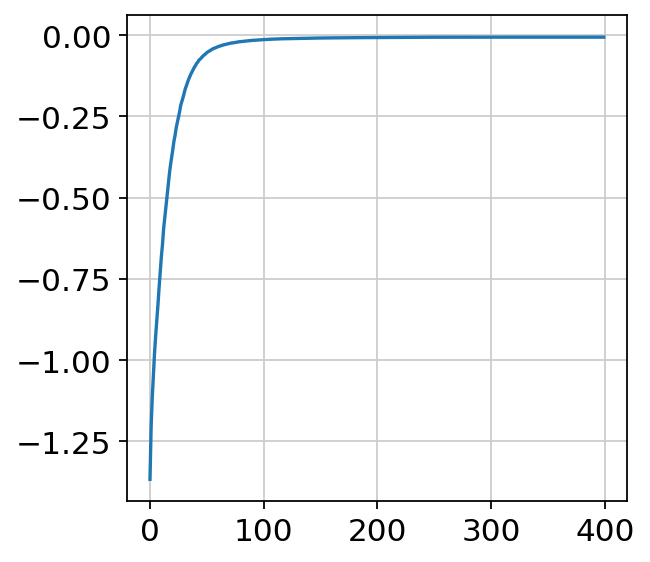

In [19]:
plt.plot(train_elbo)

In [20]:
z_mu, z_log_var, _, _ = scvi_model.z_enc(x_n.cuda(), s_n.cuda())


In [21]:
adata.obsm["X_scVI"] = z_mu.detach().cpu().numpy()
sc.pp.neighbors(adata, use_rep="X_scVI")


In [1]:
import scvi

OSError: /home/user-dnf/anaconda3/envs/hiplex/lib/python3.8/site-packages/torchtext/lib/libtorchtext.so: undefined symbol: _ZN3c1022getCustomClassTypeImplERKSt10type_index

In [ ]:
#from scvi_.model.utils import mde
sc.pp.neighbors(adata, use_rep="X_scVI")


In [ ]:
from scvi.model.utils import mde
import pymde
adata.obsm["X_mde"] = mde(adata.obsm["X_scVI"])

In [ ]:
sc.pl.embedding(
    adata,
    basis="X_mde",
    color=["tech"],
    frameon=True,
    ncols=1,
)

In [ ]:
sc.pl.embedding(adata, color="cell_ontology_class", frameon=False, basis="X_mde")


In [ ]:
sc.pl.embedding(
    adata,
    basis="X_mde",
    color=["tech"],
    frameon=True,
    ncols=1,
)

In [ ]:
sc.pl.embedding(adata, color="cell_ontology_class", frameon=False, basis="X_mde")


In [23]:

### figure out how to add kl_annealing to the training scheme 